In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from interp_helpers import plot_attribution_all_targets
%load_ext autoreload
%autoreload 2

sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [2]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [3]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

sequences = [
    'RRRRRR',
    'LLLLLL',
    'RRRRRr',
    'RRRRrr',
    'RRRrrr',
    'RRRrLr',
    'RRRrLL',
    'lRrrLL',
    'LLLrrR'
]

## Embedding erasure attribution

Set activations for a particular input token at position $i# within the sequence to 0 __after__ embedding the token (to bypass the challenge of finding a neutral token with which to mask the token).

Compute the difference between the logit predicted by the output layer of the model for a given target token with and without the token at position $i$ in the sequence.

Optionally, call the function to return the difference in probabilities instead of logits, which seems more interpretable (?) because then the difference can simply be read as the change in probability of predicting the target token, given the inclusion of the input token.

**To address**: Does this truly avoid the challenge posed by finding a neutral mask as a raw input token? It seems that perhaps the model is still biased by perturbing the token embeddings.

In [21]:
def embedding_erasure_attribution(model, sequence, stoi, target_token_idx, as_prob=False):
    """Measure influence of each input token by zeroing both its token and positional embeddings."""
    token_ids = [stoi[char] for char in sequence]
    base_input = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Get baseline prediction
    with torch.no_grad():
        base_logits, _ = model(base_input, targets=None)
        base_probs = F.softmax(base_logits[0, -1], dim=0)
        if as_prob:
            base_score = base_probs[target_token_idx].item()
        else:
            base_score = base_logits[0, -1, target_token_idx].item()
    
    attributions = []
    for i in range(len(sequence)):

        # Define hooks for token and position embeddings
        def token_embedding_hook(module, input, output):
            modified_output = output.clone()
            if len(modified_output.shape) == 3:  # [batch, seq_len, embedding_dim]
                modified_output[0, i, :] = 0.0
            elif len(modified_output.shape) == 2:  # [seq_len, embedding_dim]
                modified_output[i, :] = 0.0
            return modified_output
            
        def position_embedding_hook(module, input, output):
            modified_output = output.clone()
            if len(modified_output.shape) == 3:  # [batch, seq_len, embedding_dim]
                modified_output[0, i, :] = 0.0
            elif len(modified_output.shape) == 2:  # [seq_len, embedding_dim]
                modified_output[i, :] = 0.0
            return modified_output
        
        try:
            # Register hooks
            token_hook = model.transformer.wte.register_forward_hook(token_embedding_hook)
            pos_hook = model.transformer.wpe.register_forward_hook(position_embedding_hook)
            
            # Run forward pass with modified embeddings
            with torch.no_grad():
                masked_logits, _ = model(base_input, targets=None)
                masked_probs = F.softmax(masked_logits[0, -1], dim=0)
                if as_prob:
                    masked_score = masked_probs[target_token_idx].item()
                else:
                    masked_score = masked_logits[0, -1, target_token_idx].item()
        
        finally:
            # Remove hooks
            token_hook.remove()
            pos_hook.remove()
        
        attributions.append(base_score - masked_score)
        
    return np.array(attributions)

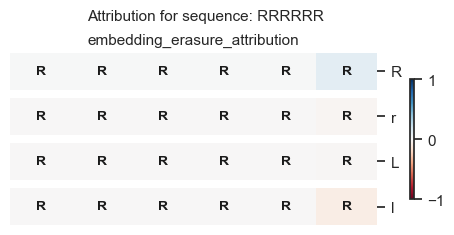

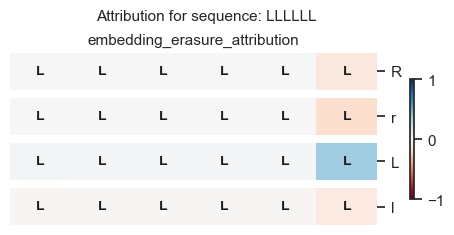

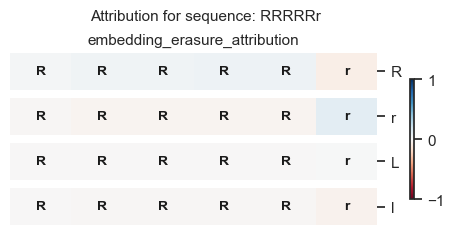

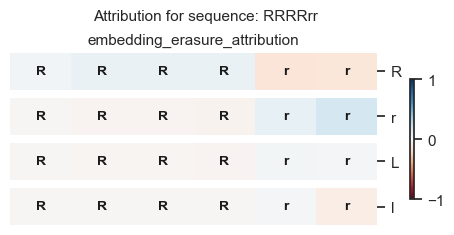

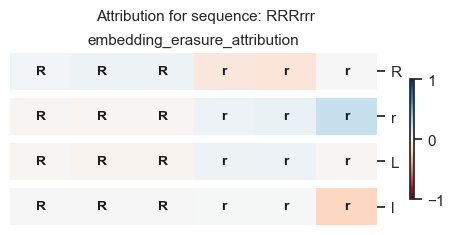

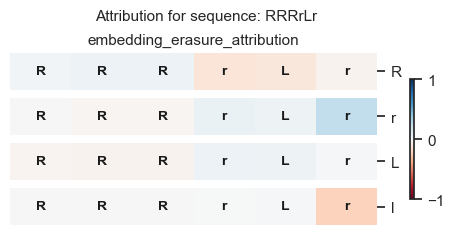

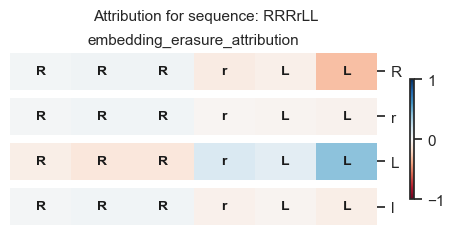

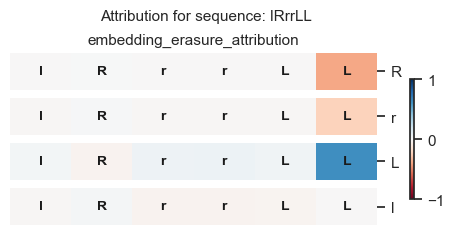

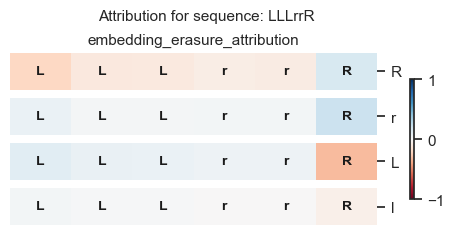

In [22]:
plot_attribution_all_targets(embedding_erasure_attribution, model, sequences, vocab, stoi, as_prob=True)

## Contrastive attribution

As an alternative to the above approach, instead of masking each input token, we instead compare the inclusion of each input token to a "baseline" defined by the average of the logits/probabilities when replacing that token with all other tokens in the vocabulary.

Clearly, this approach will become quite computationally expensive if the vocabulary or sequence length grows, but at least seems theoretically sound(?) and is doable for our small version of the model/task..

In [5]:
def contrastive_attribution(model, sequence, stoi, target_token_idx, as_prob=False):
    """Measure each token's importance by comparing against alternative tokens.
    
    For each position, compares the effect of the actual token against the 
    average effect of all other possible tokens in the vocabulary.
    """
    token_ids = [stoi[char] for char in sequence]
    base_input = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Get baseline prediction
    with torch.no_grad():
        base_logits, _ = model(base_input)
        base_probs = F.softmax(base_logits[0, -1], dim=0)
        if as_prob:
            base_score = base_probs[target_token_idx].item()
        else:
            base_score = base_logits[0, -1, target_token_idx].item()
    
    attributions = []
    for i in range(len(sequence)):
        original_token = token_ids[i]
        
        # Calculate average effect of alternative tokens
        alt_scores = []
        for alt_token in range(len(stoi)):
            if alt_token == original_token:
                continue
                
            alt_seq = token_ids.copy()
            alt_seq[i] = alt_token
            alt_input = torch.tensor(alt_seq, dtype=torch.long).unsqueeze(0).to(model.device)
            
            with torch.no_grad():
                alt_logits, _ = model(alt_input)
                alt_probs = F.softmax(alt_logits[0, -1], dim=0)
                if as_prob:
                    alt_score = alt_probs[target_token_idx].item()
                else:
                    alt_score = alt_logits[0, -1, target_token_idx].item()
                alt_scores.append(alt_score)
        
        # Average score with alternative tokens
        avg_alt_score = sum(alt_scores) / len(alt_scores)
        
        # Attribution: how much better is the actual token than alternatives?
        attributions.append(base_score - avg_alt_score)
    
    return np.array(attributions)

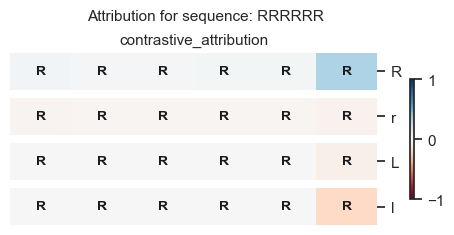

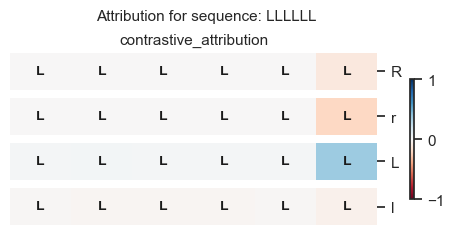

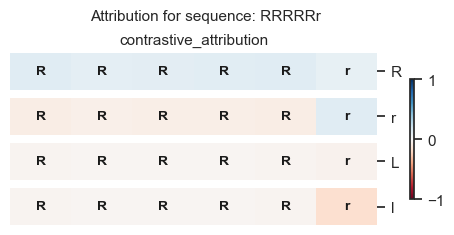

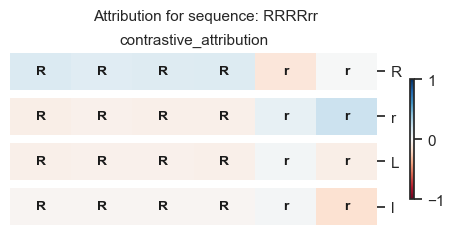

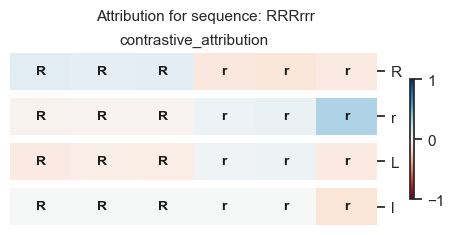

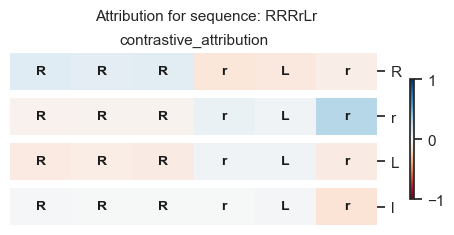

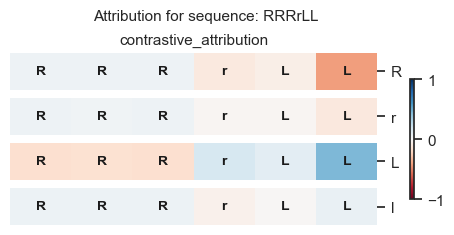

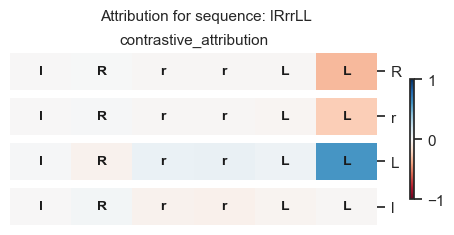

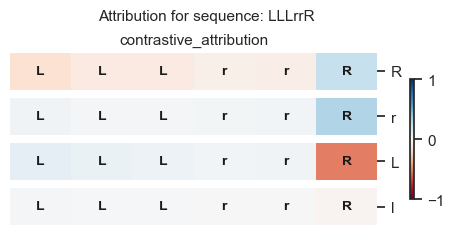

In [9]:
plot_attribution_all_targets(contrastive_attribution, model, sequences, vocab, stoi)

In [16]:
def layer_perturbation_analysis(model, sequence, stoi, target_token_idx):
    """Analyze layer importance by perturbing intermediate activations."""
    token_ids = [stoi[char] for char in sequence]
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Storage for layer activations and importance scores
    layer_activations = {}
    layer_importance = {}
    
    # First pass: capture all layer activations
    def capture_activations_hook(layer_name):
        def hook(module, input, output):
            layer_activations[layer_name] = output.detach().clone()
            return output
        return hook
    
    # Register hooks for each layer
    hooks = []
    for i, block in enumerate(model.transformer.h):
        layer_name = f"layer_{i}"
        hooks.append(block.register_forward_hook(capture_activations_hook(layer_name)))
    
    # Get baseline prediction
    with torch.no_grad():
        base_logits, _ = model(input_tensor)
        base_score = base_logits[0, -1, target_token_idx].item()
    
    # Remove hooks after capturing activations
    for hook in hooks:
        hook.remove()
    
    # Second pass: perturb each layer and measure effect
    for i, block in enumerate(model.transformer.h):
        layer_name = f"layer_{i}"
        
        # Create a hook that perturbs this layer's activations
        def perturb_hook(name):
            def hook(module, input, output):
                # Apply noise to activations (scaled to original magnitude)
                activation = layer_activations[name]
                noise = torch.randn_like(activation) * activation.std() * 0.1
                return activation + noise
            return hook
        
        # Register perturbation hook
        perturb_hook_handle = block.register_forward_hook(perturb_hook(layer_name))
        
        # Measure effect of perturbation
        with torch.no_grad():
            perturbed_logits, _ = model(input_tensor)
            perturbed_score = perturbed_logits[0, -1, target_token_idx].item()
        
        # Store importance score
        layer_importance[layer_name] = abs(base_score - perturbed_score)
        
        # Remove perturbation hook
        perturb_hook_handle.remove()
    
    return layer_importance

## LIME (Local Interpretable Model-agnostic Explanations)

Similar to other methods, begin by computing the baseline prediction from the input sequence for a given target token.

Next, randomly sample a collection of input sequences where each token has some probability of being replaced with a random alternative token from the vocabulary. For each of these perturbed sequences, compute the prediction for the target token. This creates a dataset of perturbed sequences and their corresponding predictions, on which we can then fit a linear model to learn the importance of each token (via fit coefficients).

Given the small size of the vocabulary, this appears to converge to a similar solution as the contrastive attribution approach.

In [13]:
def lime_attribution_contrastive(model, sequence, stoi, target_token_idx, n_samples=200):
    """LIME attribution using contrastive perturbation strategy."""
    from sklearn.linear_model import Ridge
    
    token_ids = [stoi[char] for char in sequence]
    seq_len = len(token_ids)
    vocab_size = len(stoi)
    
    # Get baseline prediction for original sequence
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(model.device)
    with torch.no_grad():
        base_logits, _ = model(input_tensor)
        base_probs = F.softmax(base_logits[0, -1], dim=0)
        base_score = base_probs[target_token_idx].item()
    
    # Generate samples where each token has some probability of being replaced
    # with a random alternative token from vocabulary
    perturbed_data = np.zeros((n_samples, seq_len))
    predictions = []
    
    for sample_idx in range(n_samples):
        # Decide which positions to perturb (with ~50% probability)
        perturb_mask = np.random.binomial(1, 0.5, size=seq_len)
        perturbed_seq = token_ids.copy()
        
        # For positions to perturb, choose random alternative tokens
        for pos in range(seq_len):
            if perturb_mask[pos] == 1:
                # Get a random token that's different from the original
                alt_tokens = [t for t in range(vocab_size) if t != token_ids[pos]]
                if alt_tokens:  # Make sure we have alternatives
                    perturbed_seq[pos] = np.random.choice(alt_tokens)
            
            # Record whether we kept original (0) or used alternative (1)
            perturbed_data[sample_idx, pos] = perturb_mask[pos]
        
        # Get prediction for perturbed sequence
        perturbed_tensor = torch.tensor([perturbed_seq], dtype=torch.long).to(model.device)
        with torch.no_grad():
            perturbed_logits, _ = model(perturbed_tensor)
            perturbed_probs = F.softmax(perturbed_logits[0, -1], dim=0)
            pred = perturbed_probs[target_token_idx].item()
            predictions.append(pred)
    
    # Fit interpretable model
    model_lime = Ridge(alpha=1.0)
    model_lime.fit(perturbed_data, predictions)
    
    # Return coefficients (negative because 1 means "replaced with alternative")
    # Negative coefficient means replacing hurts prediction → token is important
    return -model_lime.coef_

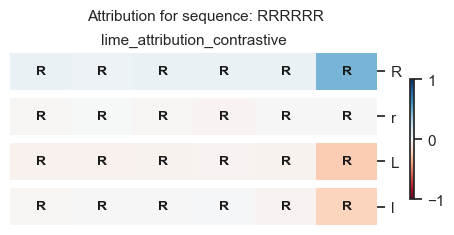

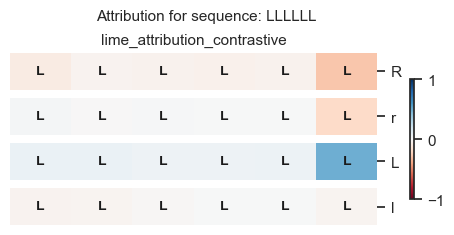

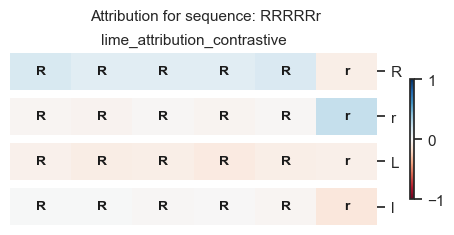

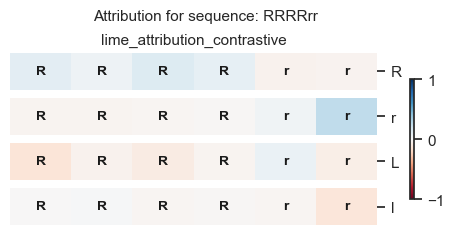

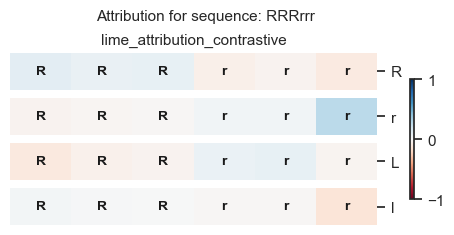

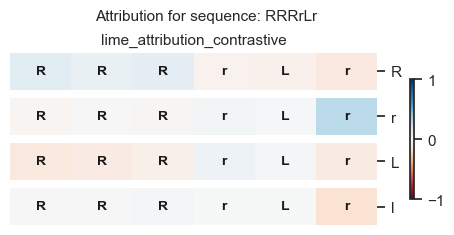

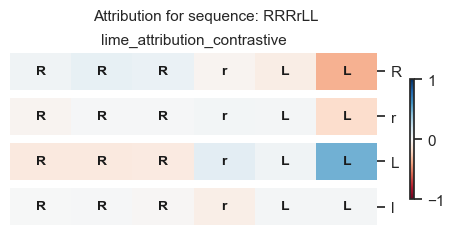

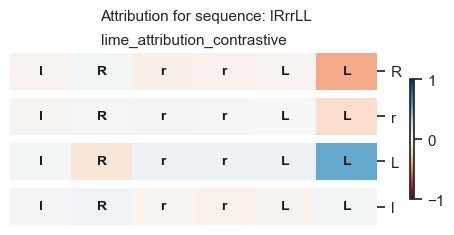

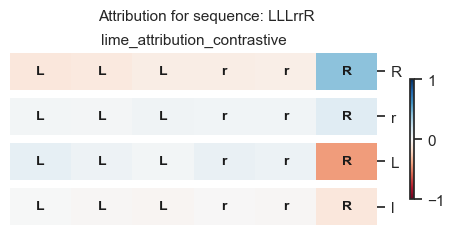

In [14]:
plot_attribution_all_targets(lime_attribution_contrastive, model, sequences, vocab, stoi)